In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set('paper')
%matplotlib inline

import lightgbm as lgb

In [2]:
metadata_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/building_metadata.csv')
train_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/train.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/weather_train.csv', parse_dates=['timestamp'])

In [3]:
train = train_df.merge(metadata_df, on='building_id', how='left')
train = train.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

In [4]:
del weather_train_df, metadata_df
gc.collect();

In [5]:
#format datetime
train['timestamp']= pd.to_datetime(train['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [6]:
train_1 = train.dropna(axis = 0, how = 'any')

In [7]:
# Below function extracts date related features from datetime
def create_date_featues(df):

    df['Year'] = pd.to_datetime(train_1['timestamp']).dt.year
    df['Month'] = pd.to_datetime(train_1['timestamp']).dt.month
    df['Day'] = pd.to_datetime(train_1['timestamp']).dt.day
    df['Hour'] = pd.to_datetime(train_1['timestamp']).dt.hour
    df['Minute'] = pd.to_datetime(train_1['timestamp']).dt.minute
    
    return df

In [8]:
train_1 = create_date_featues(train_1)

In [9]:
for col in ['meter']:
    train_1 = pd.get_dummies(train_1, columns=[col])
for col in ['primary_use']:
    train_1 = pd.get_dummies(train_1, columns=[col])
for col in ['floor_count']:
    train_1 = pd.get_dummies(train_1, columns=[col])
for col in ['cloud_coverage']:
    train_1 = pd.get_dummies(train_1, columns=[col])
for col in ['year_built']:
    train_1 = pd.get_dummies(train_1, columns=[col])
for col in ['precip_depth_1_hr']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [10]:
train_set = train_1[train_1['timestamp']<'2016-09-30 00:00:00']
test_set = train_1[train_1['timestamp']>='2016-09-30 00:00:00']

In [11]:
x_train1 = train_set.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
y_train1 = train_set.loc[:,['meter_reading']]

x_val1=test_set.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
y_val1=test_set.loc[:,['meter_reading']]

In [12]:
x_train1.shape

(242214, 98)

In [13]:
x_val1.shape

(79514, 98)

In [14]:
x_train = np.array(x_train1)
y_train = np.array(y_train1)

x_val = np.array(x_val1)
y_val = np.array(y_val1)

In [15]:
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.015,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 3000,
                    'boost_from_average': False,
                    'verbose': -1,
                }

In [16]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val)

In [17]:
%%time
evals_result = {}

model = lgb.train(lgb_params, lgb_train,
                      valid_sets=[lgb_eval], 
                      verbose_eval=100,
                      evals_result=evals_result)

[100]	valid_0's rmse: 190.621
[200]	valid_0's rmse: 100.704
[300]	valid_0's rmse: 74.0932
[400]	valid_0's rmse: 61.973
[500]	valid_0's rmse: 58.3587
[600]	valid_0's rmse: 55.9202
[700]	valid_0's rmse: 54.2116
[800]	valid_0's rmse: 53.4415
[900]	valid_0's rmse: 52.7958
[1000]	valid_0's rmse: 52.3341
[1100]	valid_0's rmse: 51.9046
[1200]	valid_0's rmse: 51.4126
[1300]	valid_0's rmse: 51.3169
[1400]	valid_0's rmse: 51.2941
[1500]	valid_0's rmse: 51.1458
[1600]	valid_0's rmse: 51.0607
[1700]	valid_0's rmse: 50.9239
[1800]	valid_0's rmse: 50.9176
[1900]	valid_0's rmse: 50.9202
[2000]	valid_0's rmse: 50.8623
[2100]	valid_0's rmse: 50.8667
[2200]	valid_0's rmse: 50.7429
[2300]	valid_0's rmse: 50.64
[2400]	valid_0's rmse: 50.5062
[2500]	valid_0's rmse: 50.3462
[2600]	valid_0's rmse: 50.275
[2700]	valid_0's rmse: 50.2757
[2800]	valid_0's rmse: 50.2573
[2900]	valid_0's rmse: 50.2885
[3000]	valid_0's rmse: 50.1681
CPU times: user 4min 57s, sys: 3.87 s, total: 5min 1s
Wall time: 40.9 s


In [18]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

In [19]:
pred = model.predict(x_val)
r2_score(y_val,pred)

0.9676588571130802

In [20]:
mean_squared_error(y_val,pred)

2516.8377732392464

In [21]:
a = pd.DataFrame(evals_result['valid_0'].values()).T

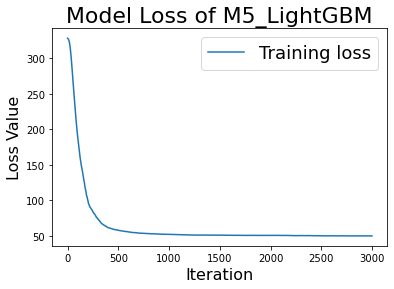

In [25]:
plt.title('Model Loss of M5_LightGBM', fontsize = 22)
sns.reset_orig()
plt.plot(a,label="Training loss")

plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Loss Value', fontsize = 16)

plt.legend(fontsize = 18)
plt.show()

In [26]:
import shap
explainer = shap.TreeExplainer(model)

In [27]:
shap_values = explainer(x_train1)

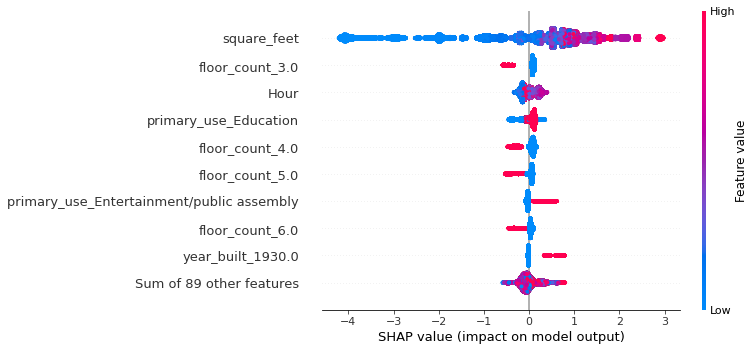

In [28]:
shap.plots.beeswarm(shap_values)

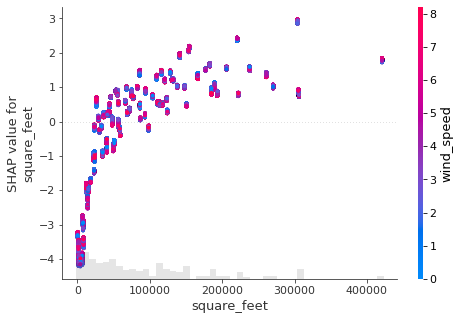

In [29]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"square_feet"], color=shap_values)

In [36]:
df_pred = pd.DataFrame(pred)
df_y_val1 = pd.DataFrame(y_val)
df_reset = df_y_val1.reset_index(drop = True)

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.reset_orig()

plt.plot(pl_train_elec,label = 'Meter Reading', color = 'tab:blue')


plt.title('Meter Reading: Electricity', fontsize = 30)
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Value', fontsize = 25)
plt.legend(fontsize = 21)

plt.show()

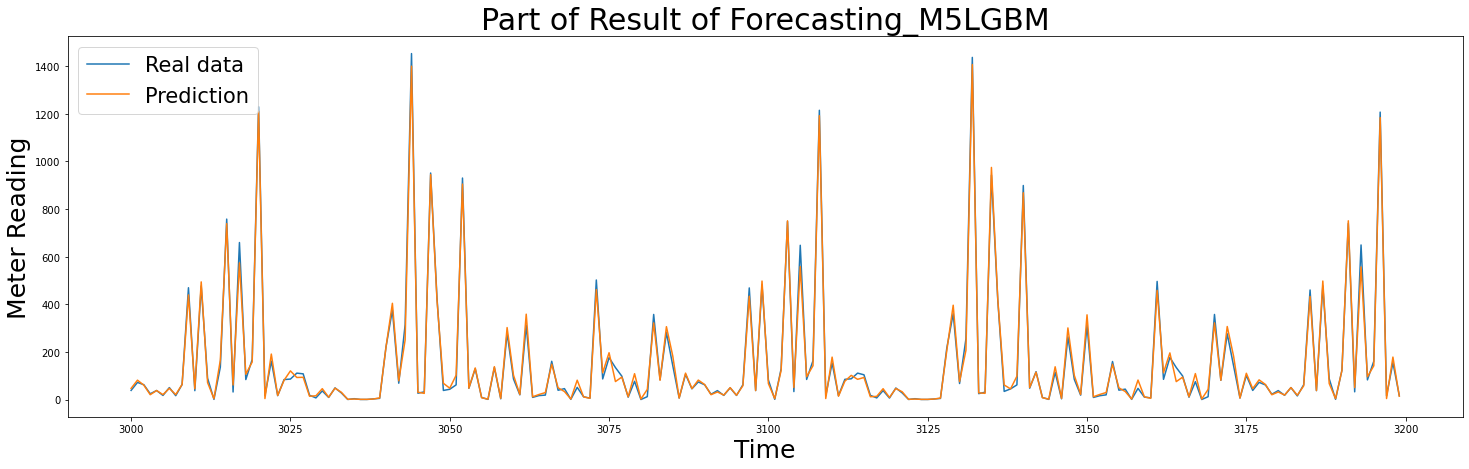

In [39]:
fig = plt.figure(figsize=(25,7))

plt.plot(df_reset[3000:3200],label = 'Real data')
plt.plot(df_pred[3000:3200],label = 'Prediction')

plt.title('Part of Result of Forecasting_M5LGBM', fontsize = 30)

plt.xlabel('Time', fontsize = 25)
plt.ylabel('Meter Reading', fontsize = 25)
plt.legend(fontsize = 21)

plt.show()